In [1]:
import pandas as pd
from data_cleaning import data_cleaning
from implied_vol import BS_implied_vol
from fit_bs import fit_BS
import os

# set the path to the previous folder
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(path)

In [19]:

option_data_spx = pd.read_csv('./Public/Data/Option/spx_option_0901.csv')
option_data_nky = pd.read_csv('./Public/Data/Option/nky_option_0901.csv')
option_data_hsi = pd.read_csv('./Public/Data/Option/hsi_option_0901.csv')


In [20]:

option_data_spx = data_cleaning(option_data_spx).format_data(index = 'SPX')
option_data_nky = data_cleaning(option_data_nky).format_data(index = 'NKY')
option_data_hsi = data_cleaning(option_data_hsi).format_data(index = 'HSI')

option_data_spx = data_cleaning(option_data_spx).check_iv_number(drop_type='volume', drop_threshold=10)
option_data_nky = data_cleaning(option_data_nky).check_iv_number(drop_type='volume', drop_threshold=2)
option_data_hsi = data_cleaning(option_data_hsi).check_iv_number()

spx_data = data_cleaning(option_data_spx).get_hist('SPX', '2021-09-01', '2023-11-13')
nky_data = data_cleaning(option_data_nky).get_hist('NKY', '2021-09-01', '2023-11-13')
hsi_data = data_cleaning(option_data_hsi).get_hist('HSI', '2021-09-01', '2023-11-13')

option_price_spx = data_cleaning(option_data_spx).extract_option_price(px_type='mid')
option_price_nky = data_cleaning(option_data_nky).extract_option_price(px_type='mid')
option_price_hsi = data_cleaning(option_data_hsi).extract_option_price(px_type='mid')



option_data = pd.concat([option_data_spx, option_data_nky, option_data_hsi], axis=0)
option_price = pd.concat([option_price_spx, option_price_nky, option_price_hsi], axis=0)

implied_params = BS_implied_vol(option_price).parity_implied_params(option_data, plot_parity=False)
implied_vol_spx = BS_implied_vol(option_price[option_price['Index'] == 'SPX']).get_iv(option_data[option_data['Index'] == 'SPX'], implied_params[implied_params['Index'] == 'SPX'], plot_iv_scatter=False)
implied_vol_nky = BS_implied_vol(option_price[option_price['Index'] == 'NKY']).get_iv(option_data[option_data['Index'] == 'NKY'], implied_params[implied_params['Index'] == 'NKY'], plot_iv_scatter=False)
implied_vol_hsi = BS_implied_vol(option_price[option_price['Index'] == 'HSI']).get_iv(option_data[option_data['Index'] == 'HSI'], implied_params[implied_params['Index'] == 'HSI'], plot_iv_scatter=False)



fwd_moneyness_spx = fit_BS(implied_vol_spx, implied_params[implied_params['Index'] == 'SPX']).get_fwd_mny()
fwd_moneyness_nky = fit_BS(implied_vol_nky, implied_params[implied_params['Index'] == 'NKY']).get_fwd_mny()
fwd_moneyness_hsi = fit_BS(implied_vol_hsi, implied_params[implied_params['Index'] == 'HSI']).get_fwd_mny()

bs_iv_curve_params_spx = fit_BS(implied_vol_spx, implied_params[implied_params['Index'] == 'SPX']).fit_BS_curve(fwd_moneyness_spx, plot_curve=False)
bs_iv_curve_params_nky = fit_BS(implied_vol_nky, implied_params[implied_params['Index'] == 'NKY']).fit_BS_curve(fwd_moneyness_nky, plot_curve=False, method='tanh')
bs_iv_curve_params_hsi = fit_BS(implied_vol_hsi, implied_params[implied_params['Index'] == 'HSI']).fit_BS_curve(fwd_moneyness_hsi, plot_curve=False)

step = 50
bs_iv_surface_spx = fit_BS(implied_vol_spx, implied_params[implied_params['Index'] == 'SPX']).fit_surface(bs_iv_curve_params_spx, plot_surface=False, step=step, type='wireframe')
bs_iv_surface_nky = fit_BS(implied_vol_nky, implied_params[implied_params['Index'] == 'NKY']).fit_surface(bs_iv_curve_params_nky, plot_surface=False, step=step)
bs_iv_surface_hsi = fit_BS(implied_vol_hsi, implied_params[implied_params['Index'] == 'HSI']).fit_surface(bs_iv_curve_params_hsi, plot_surface=False, step=step)


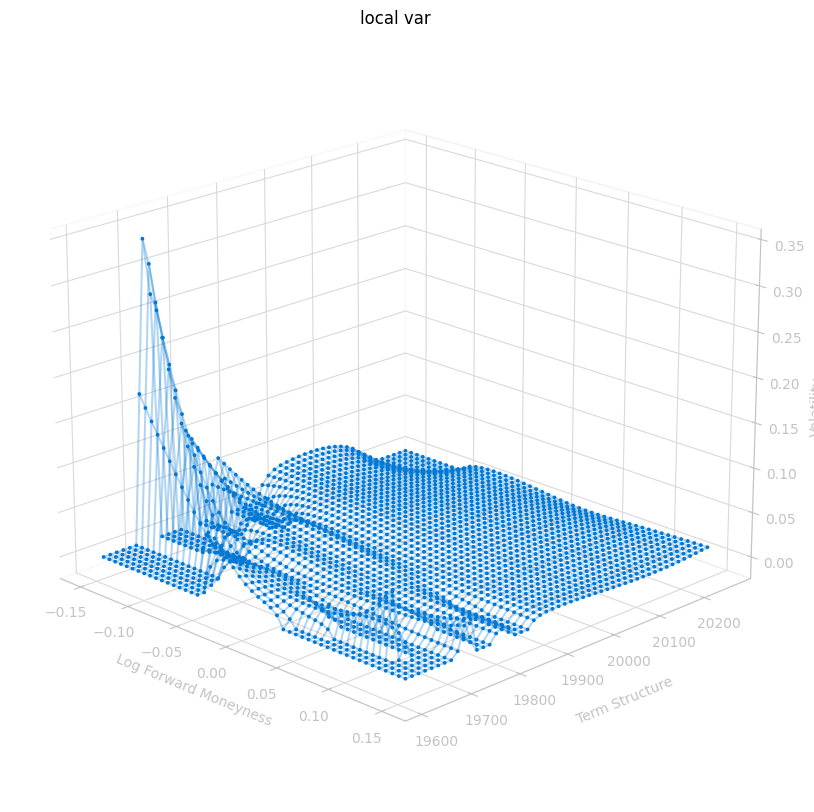

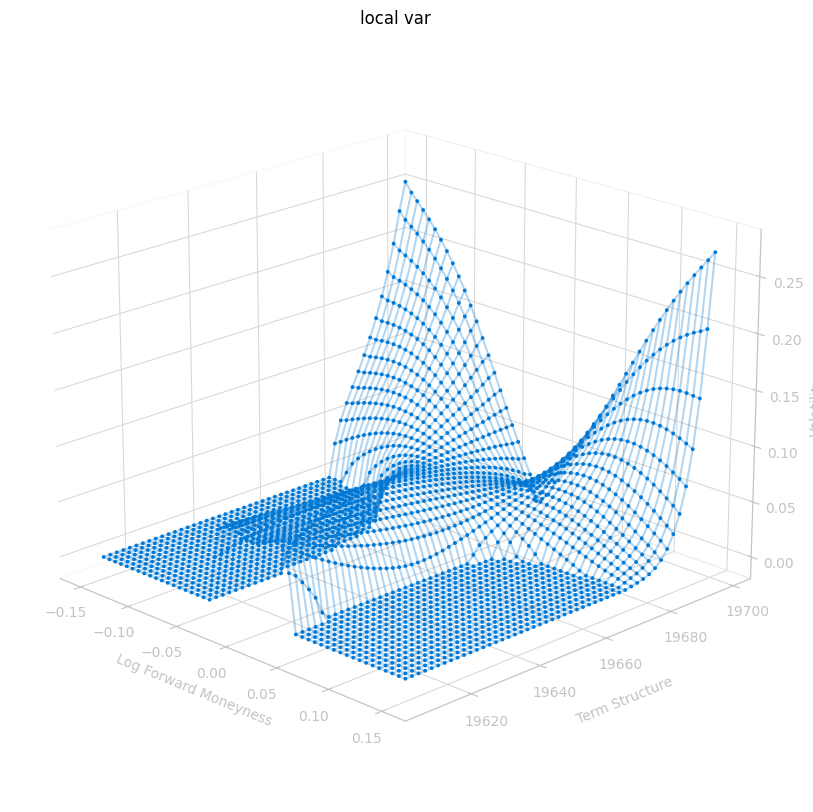

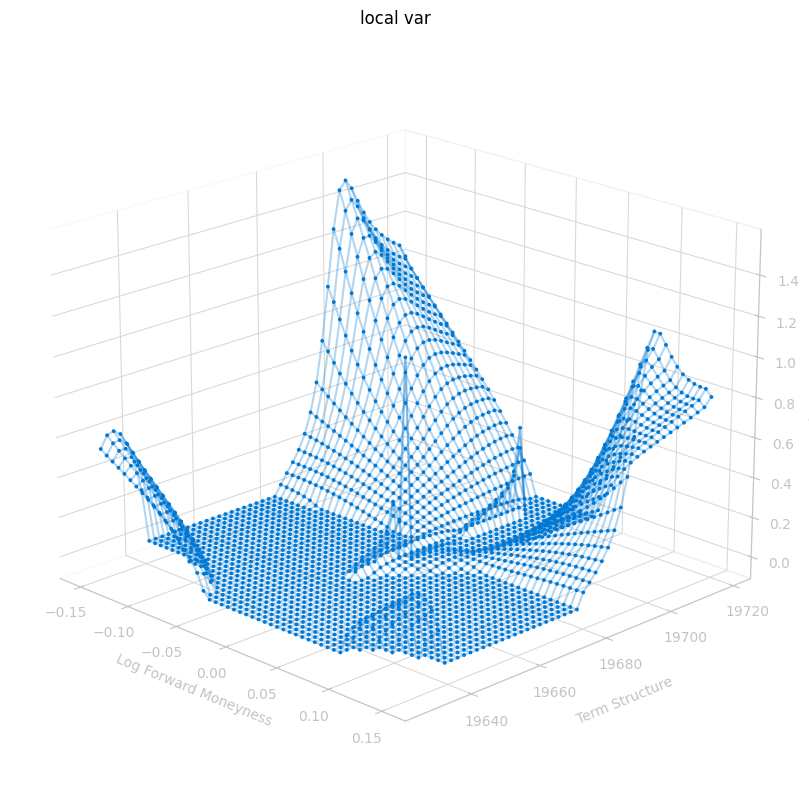

In [26]:
from matplotlib.dates import date2num, num2date
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
bs_iv_surface = bs_iv_surface_spx
def local_vol_surface(bs_iv_surface):
    expiry_list = bs_iv_surface.columns.values[:]
    fwd_mny = bs_iv_surface.index.values[:]
    # square all the entries in the surface

    bs_var_surface =  bs_iv_surface ** 2
    # display(bs_var_surface)
    # display(bs_var_surface.iloc[:, 0])

    # calculate delta t
    delta_t = (num2date(expiry_list[1]) - num2date(expiry_list[0])).days / 365
    # print(delta_t)
    # print(fwd_mny)

    # for each point in the surface, calculate the local val
    local_var_surface = pd.DataFrame(index=fwd_mny, columns=expiry_list)
    for i, expiry in enumerate(expiry_list):
        for j, mny in enumerate(fwd_mny):
            w = bs_var_surface.iloc[j, i]
            y = fwd_mny[j]

            if i == 0:
                numerator = (bs_var_surface.iloc[j, i+1] - bs_var_surface.iloc[j, i]) / delta_t
            elif i == len(expiry_list) - 1:
                numerator = (bs_var_surface.iloc[j, i] - bs_var_surface.iloc[j, i-1]) / delta_t
            else:
                numerator = (bs_var_surface.iloc[j, i+1] - bs_var_surface.iloc[j, i-1]) / (2 * delta_t)
            
            if j == 0:
                dwdy = (bs_var_surface.iloc[j+1, i] - bs_var_surface.iloc[j, i]) / (fwd_mny[j+1] - fwd_mny[j])
                d2wdy2 = (bs_var_surface.iloc[j+2, i] - 2 * bs_var_surface.iloc[j+1, i] + bs_var_surface.iloc[j, i]) / ((fwd_mny[j+2] - fwd_mny[j+1]) * (fwd_mny[j+1] - fwd_mny[j]))
            elif j == len(fwd_mny) - 1:
                dwdy = (bs_var_surface.iloc[j, i] - bs_var_surface.iloc[j-1, i]) / (fwd_mny[j] - fwd_mny[j-1])
                d2wdy2 = (bs_var_surface.iloc[j, i] - 2 * bs_var_surface.iloc[j-1, i] + bs_var_surface.iloc[j-2, i]) / ((fwd_mny[j] - fwd_mny[j-1]) * (fwd_mny[j-1] - fwd_mny[j-2]))
            else:
                dwdy = (bs_var_surface.iloc[j+1, i] - bs_var_surface.iloc[j-1, i]) / (fwd_mny[j+1] - fwd_mny[j-1])
                d2wdy2 = (bs_var_surface.iloc[j+1, i] - 2 * bs_var_surface.iloc[j, i] + bs_var_surface.iloc[j-1, i]) / ((fwd_mny[j+1] - fwd_mny[j]) * (fwd_mny[j] - fwd_mny[j-1]))
            
            local_var = numerator / (1 - y/w * dwdy + (-0.25 - 1/w + y**2/w**2)*(dwdy)**2/4 + 0.5*d2wdy2)
            local_var_surface.iloc[j, i] = local_var

    # set the negative values to 0
    local_var_surface[local_var_surface < 0] = 0
    local_var_surface = local_var_surface.astype(float)
    # take the square_root of the local var surface, avoid TypeError: loop of ufunc does not support argument 0 of type int which has no callable sqrt method
    local_vol_surface = np.sqrt(local_var_surface)
    # display(local_vol_surface)
    # display(local_var_surface)

    # plot
    X, Y = np.meshgrid(fwd_mny, expiry_list)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, local_vol_surface.T.values, color='#0078d4', alpha=0.3)


    # change the y-axis to date
    # expiry_grid = num2date(expiry_list)
    # expiry_grid = [expiry.strftime('%Y-%m-%d') for expiry in expiry_list]
    # ax.set_yticklabels(expiry_list)

    # Plot the scatter
    ax.scatter(X, Y, local_vol_surface.T.values, color='#0078d4', alpha=1, s=3)

    # Make the surface transparent
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  '#d9d9d9'
    ax.yaxis._axinfo["grid"]['color'] =  '#d9d9d9'
    ax.zaxis._axinfo["grid"]['color'] =  '#d9d9d9'

    # Set labels and title
    # title = index + ' Implied Volatility Surface'
    title = 'local var'
    title = ''.join(title)
    ax.set_title(title)
    ax.set_xlabel('Log Forward Moneyness')
    ax.set_ylabel('Term Structure')
    ax.set_zlabel('Volatility')

    # make xlabel away from the plot
    ax.yaxis.labelpad = 10

    # Adjust tick size
    ax.tick_params(axis='both', which='major', labelsize=10)
    # set axis color
    ax.xaxis.label.set_color('#c3c3c3')
    ax.yaxis.label.set_color('#c3c3c3')
    ax.zaxis.label.set_color('#c3c3c3')

    # set tick color
    ax.tick_params(axis='x', colors='#c3c3c3')
    ax.tick_params(axis='y', colors='#c3c3c3')
    ax.tick_params(axis='z', colors='#c3c3c3')

    # set axis color
    ax.xaxis.line.set_color('#c3c3c3')
    ax.yaxis.line.set_color('#c3c3c3')
    ax.zaxis.line.set_color('#c3c3c3')

    # Add grid lines with a dashed style
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.view_init(elev=20, azim=135)
    # invert x-axis
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.show()

    return local_vol_surface

local_vol_surface_spx = local_vol_surface(bs_iv_surface_spx)
local_vol_surface_nky = local_vol_surface(bs_iv_surface_nky)
local_vol_surface_hsi = local_vol_surface(bs_iv_surface_hsi)